## AutoEncoder

### 01 라이브러리, hyperparameter 정의

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split

from torchvision import transforms
from torchvision.datasets import FashionMNIST

from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_path = "./sample_data/"

# hyper-parameter 정의
test_data_ratio = 0.3

random_state = 0

input_size = 28 * 28

encoder_hidden_size1 = 512
encoder_hidden_size2 = 128
encoder_hidden_size3 = 32

decoder_hidden_size1 = 32
decoder_hidden_size2 = 128
decoder_hidden_size3 = 28 * 28

learning_rate = 5e-3
epochs = 50
batch_size = 32

criterion = nn.MSELoss()

num_visualization = 5

### 02 DataLoader 정의

In [2]:
class AutoEncoderDataLoader:
    def __init__(self, data_path, batch_size):
        self.data_path = data_path
        self.batch_size = batch_size
        self.transform = transforms.ToTensor()

    def __call__(self, flag):
        if flag=="train":
            dataset = FashionMNIST(
                self.data_path, train = True, download = True, transform = self.transform
            )
        else:
            dataset = FashionMNIST(
                self.data_path, train = False, download = True, transform = self.transform
            )

        data_loader = DataLoader(
            dataset,
            batch_size = self.batch_size,
            shuffle = True,
            drop_last = True,
            num_workers = 0
        )

        return data_loader


In [4]:
data_loader = AutoEncoderDataLoader(data_path, batch_size)
data_loader

In [5]:
train_loader = data_loader("train")
test_loader = data_loader("test")

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.79MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.5MB/s]


### 03 AutoEncoder 정의

In [10]:
class Autoencoder(nn.Module):
    def __init__(
        self,
        input_size,
        encoder_hidden_size1,
        encoder_hidden_size2,
        encoder_hidden_size3,
        decoder_hidden_size1,
        decoder_hidden_size2,
        decoder_hidden_size3,
    ):
        super(Autoencoder, self).__init__()
        self.input_size = input_size
        self.encoder_hidden_size1 = encoder_hidden_size1
        self.encoder_hidden_size2 = encoder_hidden_size2
        self.encoder_hidden_size3 = encoder_hidden_size3
        self.decoder_hidden_size1 = decoder_hidden_size1
        self.decoder_hidden_size2 = decoder_hidden_size2
        self.decoder_Hidden_size3 = decoder_hidden_size3

        self.encoder = nn.Sequential(
            nn.Linear(input_size, encoder_hidden_size1),
            nn.ReLU(),
            nn.Linear(encoder_hidden_size1, encoder_hidden_size2),
            nn.ReLU(),
            nn.Linear(encoder_hidden_size2, encoder_hidden_size3),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoder_hidden_size3, decoder_hidden_size1),
            nn.ReLU(),
            nn.Linear(decoder_hidden_size1, decoder_hidden_size2),
            nn.ReLU(),
            nn.Linear(decoder_hidden_size2, decoder_hidden_size3)
        )

    def forward(self, data):
        data = self.prepare_input(data)
        encoder_result = self.encoder(data)
        decoder_result = self.decoder(encoder_result)
        return decoder_result

    def prepare_input(self, data):
        flattened_data = data.view(data.size(0), -1)
        return flattened_data





In [11]:
auto_encoder = Autoencoder(
    input_size,
    encoder_hidden_size1,
    encoder_hidden_size2,
    encoder_hidden_size3,
    decoder_hidden_size1,
    decoder_hidden_size2,
    decoder_hidden_size3,
).to(device)
optimizer = torch.optim.Adam(auto_encoder.parameters(), lr=learning_rate)

In [12]:
auto_encoder

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
  )
)

In [13]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0
)

### 04 모델 학습하기

In [14]:
class Trainer:
    def __init__(self, model, data_loader, optimizer, criterion, epochs, device):
        self.model = model
        self.data_loader = data_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.epochs = epochs
        self.device = device

    def train(self):
        self.model.train()

        for epoch in range(self.epochs):
            print(f"Epoch {epoch + 1} / {self.epochs}")
            for data, _ in self.data_loader:
                self.optimizer.zero_grad()
                data = data.to(self.device)
                result = self.model(data)

                result, label = result.reshape(data.size(0), -1), data.reshape(
                    data.size(0), -1
                )
                loss = self.criterion(result, label)

                loss.backward()
                self.optimizer.step()


auto_encoder_trainer = Trainer(
    auto_encoder, train_loader, optimizer, criterion, epochs, device
)
auto_encoder_trainer.train()


Epoch 1 / 50
Epoch 2 / 50
Epoch 3 / 50
Epoch 4 / 50
Epoch 5 / 50
Epoch 6 / 50
Epoch 7 / 50
Epoch 8 / 50
Epoch 9 / 50
Epoch 10 / 50
Epoch 11 / 50
Epoch 12 / 50
Epoch 13 / 50
Epoch 14 / 50
Epoch 15 / 50
Epoch 16 / 50
Epoch 17 / 50
Epoch 18 / 50
Epoch 19 / 50
Epoch 20 / 50
Epoch 21 / 50
Epoch 22 / 50
Epoch 23 / 50
Epoch 24 / 50
Epoch 25 / 50
Epoch 26 / 50
Epoch 27 / 50
Epoch 28 / 50
Epoch 29 / 50
Epoch 30 / 50
Epoch 31 / 50
Epoch 32 / 50
Epoch 33 / 50
Epoch 34 / 50
Epoch 35 / 50
Epoch 36 / 50
Epoch 37 / 50
Epoch 38 / 50
Epoch 39 / 50
Epoch 40 / 50
Epoch 41 / 50
Epoch 42 / 50
Epoch 43 / 50
Epoch 44 / 50
Epoch 45 / 50
Epoch 46 / 50
Epoch 47 / 50
Epoch 48 / 50
Epoch 49 / 50
Epoch 50 / 50


### 05 테스트하기

Auto Encoder MSE Loss: 0.016986848562597655


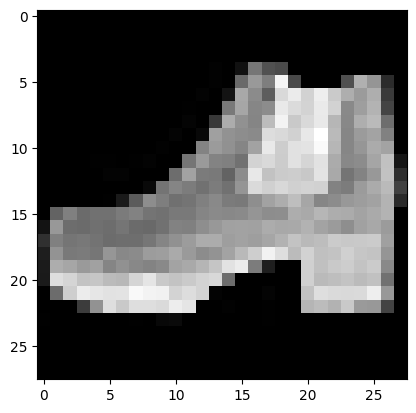

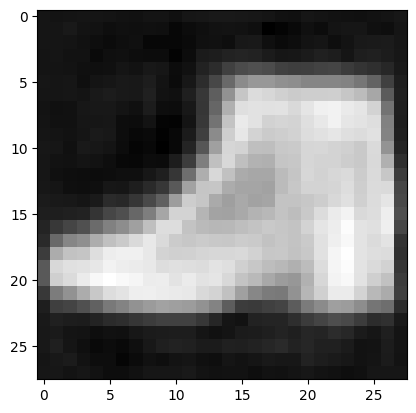

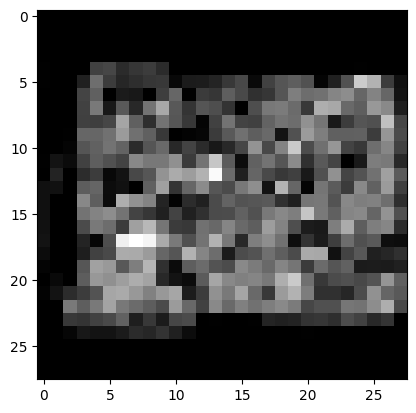

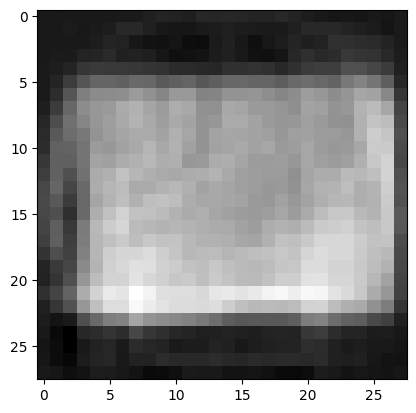

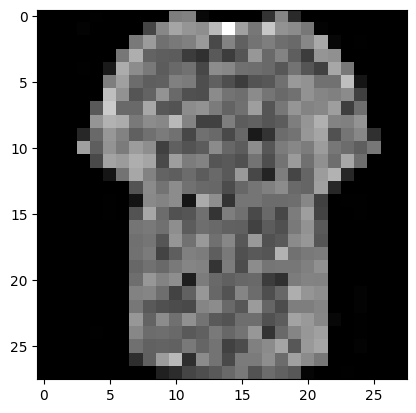

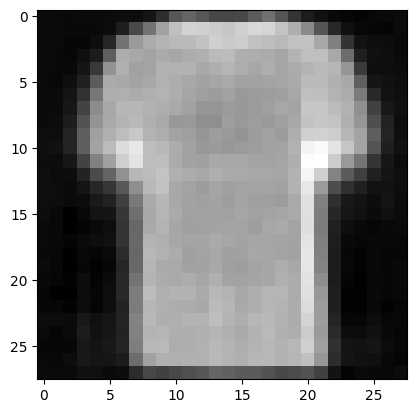

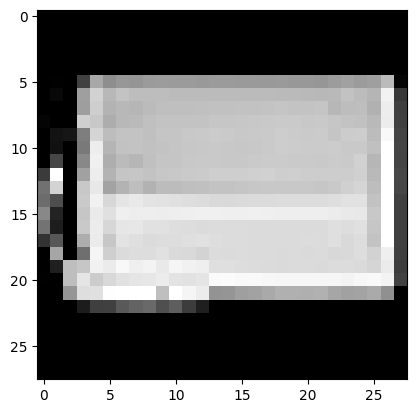

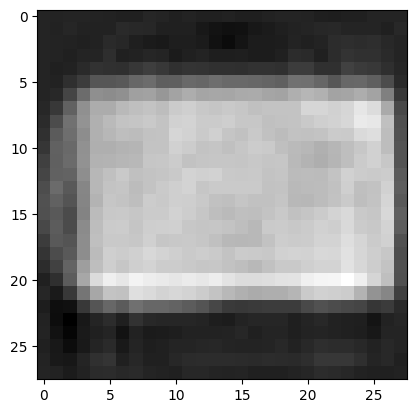

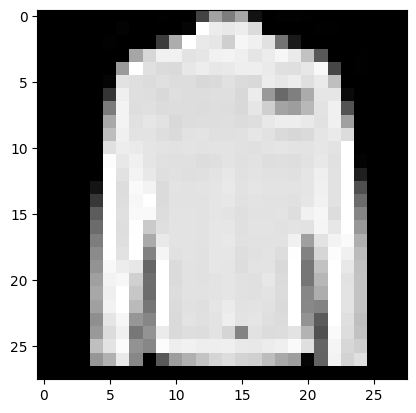

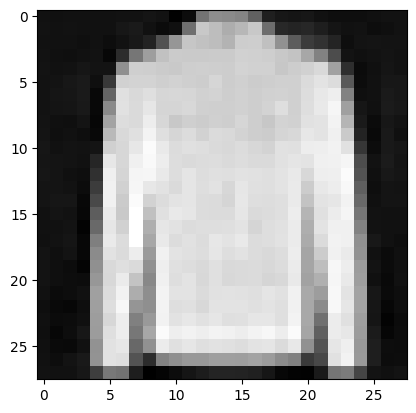

In [15]:
class Tester:
    def __init__(self, model, data_loader, criterion, num_visualization, device):
        self.model = model
        self.data_loader = data_loader
        self.criterion = criterion
        self.num_visualization = num_visualization
        self.device = device
        self.reconstructed_data = []

    def test(self):
        self.model.eval()

        mse = 0.0
        with torch.no_grad():
            for data, label in self.data_loader:
                data, label = data.to(self.device), label.to(self.device)
                result = self.model(data)

                result, label = result.reshape(data.size(0), -1), data.reshape(
                    data.size(0), -1
                )
                self.reconstructed_data.append(result.cpu().numpy())

                loss = self.criterion(result, label)
                mse += loss.item()
            print("Auto Encoder MSE Loss: {}".format(mse / len(self.data_loader)))

    def visualize(self):
        with torch.no_grad():
            for index, (data, label) in enumerate(self.data_loader):
                if index < self.num_visualization:
                    data, _ = data.to(self.device), label.to(self.device)
                    result = self.model(data)

                    pyplot.imshow(data[0].cpu().reshape(28, 28), cmap="gray")
                    pyplot.show()

                    pyplot.imshow(result[0].cpu().reshape(28, 28), cmap="gray")
                    pyplot.show()


auto_encoder_tester = Tester(
    auto_encoder, test_loader, criterion, num_visualization, device
)
auto_encoder_tester.test()
auto_encoder_tester.visualize()